# Importing all necessary modules

In [97]:
# Basic libraries
import pandas as pd
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import collections

# Others
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, make_scorer, roc_curve, confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import itertools
import warnings
warnings.filterwarnings("ignore")

# Understanding the data

We are going to use credit card transaction data which has been modified to protect the sensitive information. Instead of using the real features, the data contains PCA transformed features. In addition to 28 PCA features, we also have two features that were not transformed and these are: time and amount. 

Time: the seconds elapsed between each transaction and the first transaction in the dataset <br>
Amount: amount of the transaction.

The response variable is mentioned in the column called "Class" which takes value 1 if the transaction was a fraud transaction otherwise it takes value 0.

In [2]:
df = pd.read_csv("./data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
null_num = df.isnull().sum().max()
print("Total null values in the dataframe: {}".format(null_num))

Total null values in the dataframe: 0


In [5]:
print("Positive class (fraud transactions) are {0:.2f}% of the dataset".format(100*df["Class"].value_counts()[1]/len(df)))

Positive class (fraud transactions) are 0.17% of the dataset


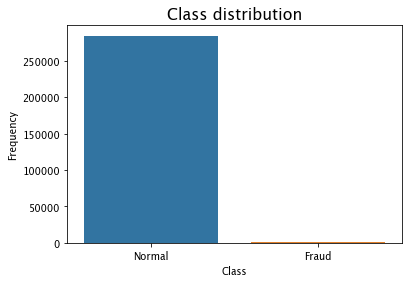

In [7]:
labels = ["Normal", "Fraud"]
sns.countplot(x="Class", data = df)
plt.title("Class distribution", fontsize=16)
plt.xticks(range(2), labels)
plt.ylabel("Frequency")
plt.show()

**Note**: We can see that the classes are highly imbalanced with majority of the transactions belong to non-fraud class. 

We will check the distribution of other two known features, Time and the amount spent. 

### Distributions of Time and amount 

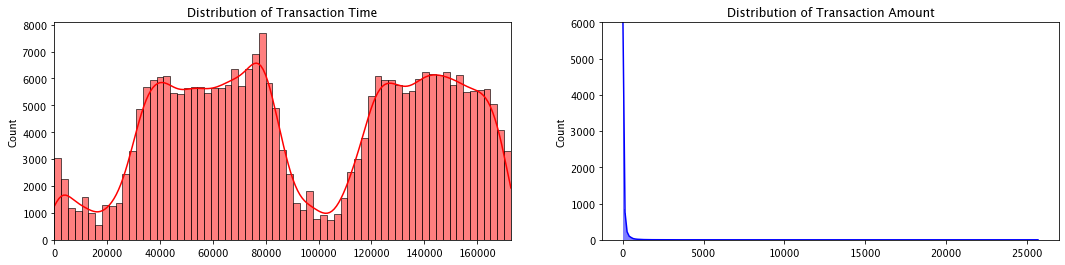

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amounts = df["Amount"].values
times = df["Time"].values

sns.histplot(times, ax=ax[0], color='r', kde=True)
ax[0].set_title("Distribution of Transaction Time")
ax[0].set_xlim([min(times), max(times)])

sns.histplot(amounts, ax=ax[1], color='b', kde=True)
ax[1].set_title("Distribution of Transaction Amount")
# ax[1].set_xlim([min(amounts), max(amounts)])
ax[1].set_ylim([0, 6000])

plt.show()

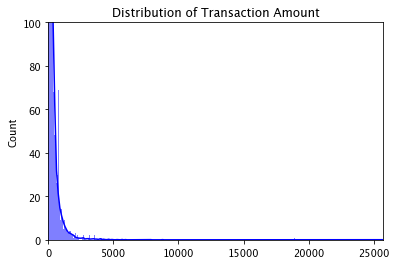

In [12]:
sns.histplot(amounts, color='b', kde=True)
plt.title("Distribution of Transaction Amount")
plt.xlim([min(amounts), max(amounts)])
plt.ylim([0, 100])
plt.show()

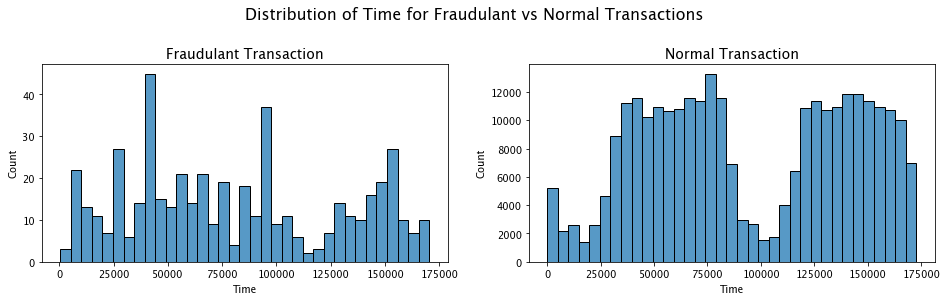

In [24]:
# First checking the distributions of time for fraud vs normal transactions
plt.subplots(figsize=(16, 8))

plt.subplot(2, 2, 1)
sns.histplot(df[df["Class"]==1].Time, bins=35)
plt.title("Fraudulant Transaction", fontsize=14)

plt.subplot(2, 2, 2)
sns.histplot(df[df["Class"]==0].Time, bins=35)
plt.title("Normal Transaction", fontsize=14)

plt.suptitle("Distribution of Time for Fraudulant vs Normal Transactions", fontsize=16)

plt.show()


## Observations:

* Most of the transactions are small in amount with median amount being USD 88. 
* There are no NULL values in the data.
* Positive class represents only 0.17% of the dataset indicating highly imbalanced data.

# Feature Scaling and transformation:
Time and Amount column range needs to be scaled for most of our prediction algorithms. That is why we will use RobustScaler as it robust to the outliers.

In [25]:
time_scaler = RobustScaler()
amount_scaler = RobustScaler()
# dropping the time and amount after scaling
df["amount_scaled"] = amount_scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["time_scaled"] = time_scaler.fit_transform(df["Time"].values.reshape(-1, 1))
df.drop(["Time", "Amount"], axis=1, inplace=True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


## Performing random under sampling

In [30]:
print("Total number of fraud and non-fraud samples are:")
print(df["Class"].value_counts())

Total number of fraud and non-fraud samples are:
0    284315
1       492
Name: Class, dtype: int64


In [31]:
# shuffle the data
df = df.sample(frac=1)

# 492 fraud cases in total
df_fraud = df.loc[df["Class"]==1]
df_non_fraud = df.loc[df["Class"]==0][:492]

new_usmpl_df = pd.concat([df_fraud, df_non_fraud])
new_usmpl_df = new_usmpl_df.sample(frac=1, random_state=42)

new_usmpl_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
195252,-3.336464,-0.512920,-1.705290,-0.804790,2.940307,-0.085578,-0.132536,1.001794,-1.104166,-0.565767,...,0.675267,-1.703679,-0.753351,1.081822,1.219175,0.161194,-0.736038,0,-0.048907,0.543662
79883,-1.322789,1.552768,-2.276921,2.992117,-1.947064,-0.480288,-1.362388,0.953242,-2.329629,-3.393553,...,-0.195200,0.590711,-0.233378,-0.164285,-0.277498,0.428610,0.246394,1,3.465381,-0.310976
138304,1.243198,-0.485756,0.270497,-0.591743,-0.915868,-0.479161,-0.781620,0.117729,-0.920119,0.301022,...,0.266420,0.026916,0.122800,0.205412,-0.283250,0.033802,0.037091,0,0.178858,-0.024730
52521,1.001992,0.047938,-0.349002,1.493958,0.186939,0.190966,-0.001112,0.147140,0.580415,-0.792938,...,-1.014315,-0.128427,-0.946242,0.456090,-0.453206,0.046627,0.064698,1,1.173618,-0.460426
262826,-0.417340,4.700055,-7.521767,7.671884,0.260821,-2.646693,-2.854432,0.958783,-4.588536,-6.120715,...,-0.437708,-0.090358,-0.742802,-0.312361,0.502575,0.821390,0.372379,1,-0.296653,0.892550


In [32]:
print("Total number of fraud and non-fraud samples after under-sampling are:")
new_usmpl_df["Class"].value_counts()

Total number of fraud and non-fraud samples after under-sampling are:


0    492
1    492
Name: Class, dtype: int64

### Checking correlation among features:

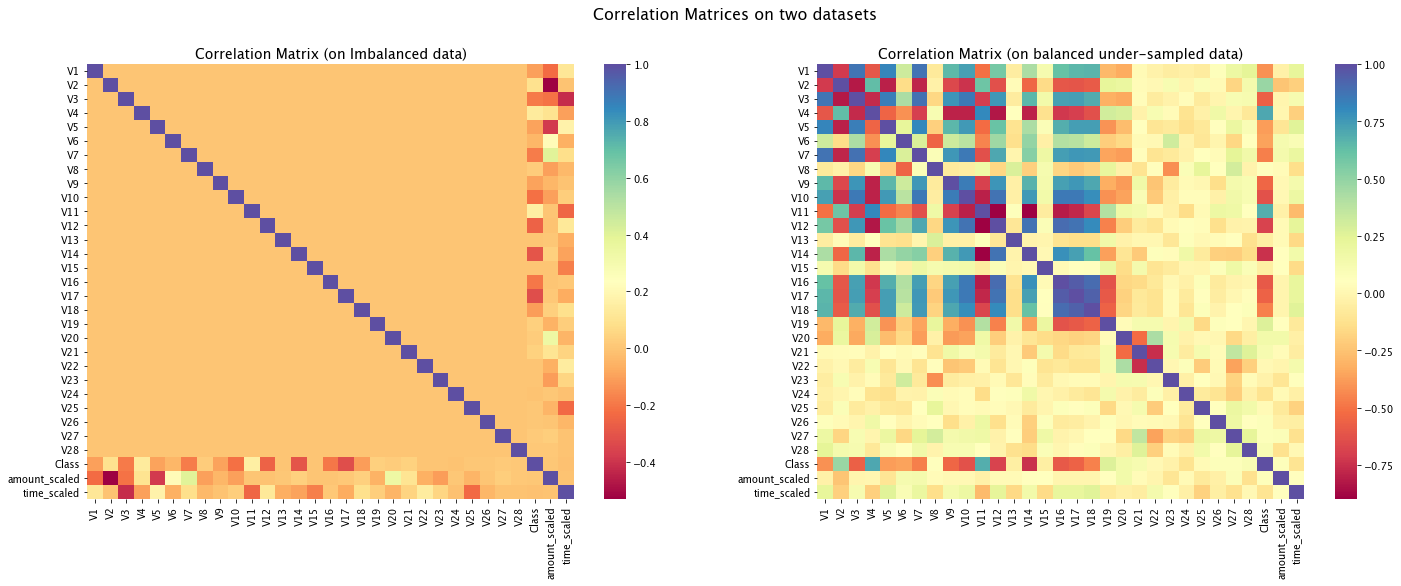

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# creating the correlation matrix for the originial df
corr = df.corr()
sns.heatmap(corr, cmap='Spectral', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix (on Imbalanced data)", fontsize=14)

# creating the correlation matrix for the under-sampled dataframe
corr = new_usmpl_df.corr()
sns.heatmap(corr, cmap='Spectral', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Correlation Matrix (on balanced under-sampled data)", fontsize=14)

f.suptitle("Correlation Matrices on two datasets", fontsize=16)

plt.show()

**Observation:**

* Positive correlation: Features V2, V4, V11 and V19 seem to have high positive correlation with the target variable.
* Negative correlation: Features V10, V12, V14 and V16 seem to have high positive correlation with the target variable.

We will try to visualize these features separately for fradulent and non-fradulent cases using box-plots.

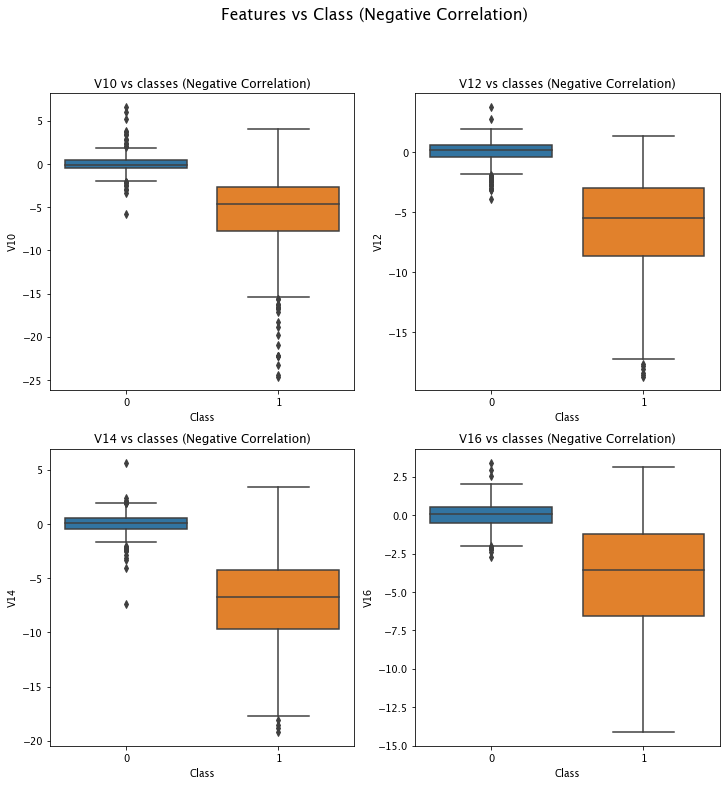

In [43]:
# Negative correlation box plots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

sns.boxplot(x="Class", y="V10", data=new_usmpl_df, ax=ax1)
ax1.set_title("V10 vs classes (Negative Correlation)")

sns.boxplot(x="Class", y="V12", data=new_usmpl_df, ax=ax2)
ax2.set_title("V12 vs classes (Negative Correlation)")

sns.boxplot(x="Class", y="V14", data=new_usmpl_df, ax=ax3)
ax3.set_title("V14 vs classes (Negative Correlation)")

sns.boxplot(x="Class", y="V16", data=new_usmpl_df, ax=ax4)
ax4.set_title("V16 vs classes (Negative Correlation)")

f.suptitle("Features vs Class (Negative Correlation)", fontsize=16)
plt.show()

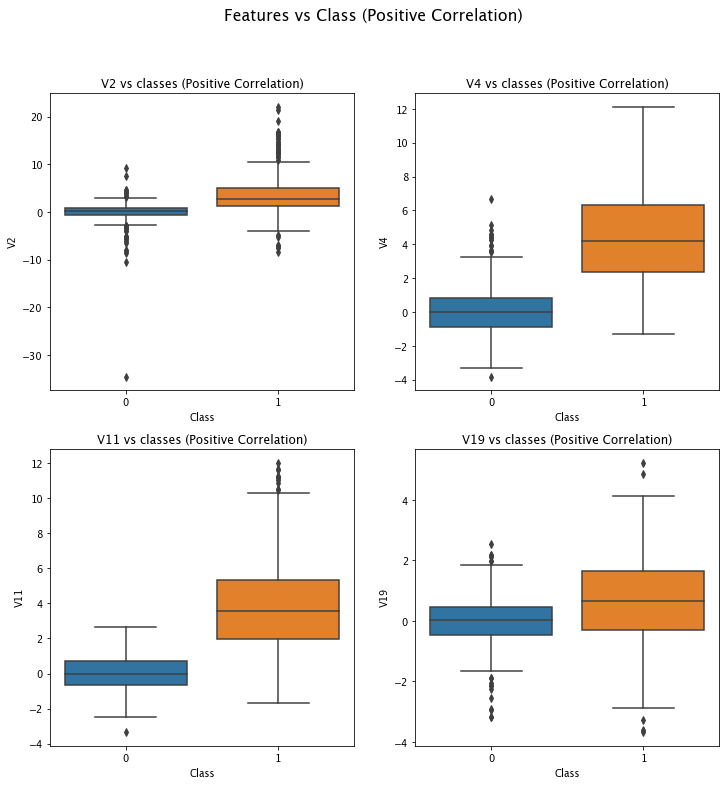

In [44]:
# Positive correlation box plots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

sns.boxplot(x="Class", y="V2", data=new_usmpl_df, ax=ax1)
ax1.set_title("V2 vs classes (Positive Correlation)")

sns.boxplot(x="Class", y="V4", data=new_usmpl_df, ax=ax2)
ax2.set_title("V4 vs classes (Positive Correlation)")

sns.boxplot(x="Class", y="V11", data=new_usmpl_df, ax=ax3)
ax3.set_title("V11 vs classes (Positive Correlation)")

sns.boxplot(x="Class", y="V19", data=new_usmpl_df, ax=ax4)
ax4.set_title("V19 vs classes (Positive Correlation)")

f.suptitle("Features vs Class (Positive Correlation)", fontsize=16)
plt.show()

### Removing the outliers from the highly correlated features:

In [33]:
print("Total samples before removing outliers: {}".format(len(new_usmpl_df)))

# Removing outliers from V14
v14_fraud = new_usmpl_df["V14"].loc[new_usmpl_df["Class"]==1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cutoff = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cutoff, q75 + v14_cutoff
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print("Total number of outliers for feature V14: {}".format(len(outliers)))
new_usmpl_df = new_usmpl_df.drop(new_usmpl_df[(new_usmpl_df["V14"] > v14_upper) | (new_usmpl_df["V14"] < v14_lower)].index)

# Removing outliers from V10
v10_fraud = new_usmpl_df["V10"].loc[new_usmpl_df["Class"]==1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cutoff = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cutoff, q75 + v10_cutoff
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print("Total number of outliers for feature v10: {}".format(len(outliers)))
new_usmpl_df = new_usmpl_df.drop(new_usmpl_df[(new_usmpl_df["V10"] > v10_upper) | (new_usmpl_df["V10"] < v10_lower)].index)

# Removing outliers from V12
v12_fraud = new_usmpl_df["V12"].loc[new_usmpl_df["Class"]==1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cutoff = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cutoff, q75 + v12_cutoff
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print("Total number of outliers for feature V12: {}".format(len(outliers)))
new_usmpl_df = new_usmpl_df.drop(new_usmpl_df[(new_usmpl_df["V12"] > v12_upper) | (new_usmpl_df["V12"] < v12_lower)].index)

print("Total samples after removing outliers: {}".format(len(new_usmpl_df)))

Total samples before removing outliers: 984
Total number of outliers for feature V14: 4
Total number of outliers for feature v10: 25
Total number of outliers for feature V12: 15
Total samples after removing outliers: 938


## Dimensionality reduction to see the separation between classes:

### t-SNE algorithm:

In [34]:
X = new_usmpl_df.drop("Class", axis=1)
y = new_usmpl_df["Class"]

# t-SNE starts here
tsne_start = time.time()
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
tsne_end = time.time()
print("Time taken for t-SNE: {}".format(tsne_end - tsne_start))

# PCA algo
pca_start = time.time()
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
pca_end = time.time()
print("Time taken for PCA: {}".format(pca_end - pca_start))


Time taken for t-SNE: 2.1230740547180176
Time taken for PCA: 1.7652652263641357


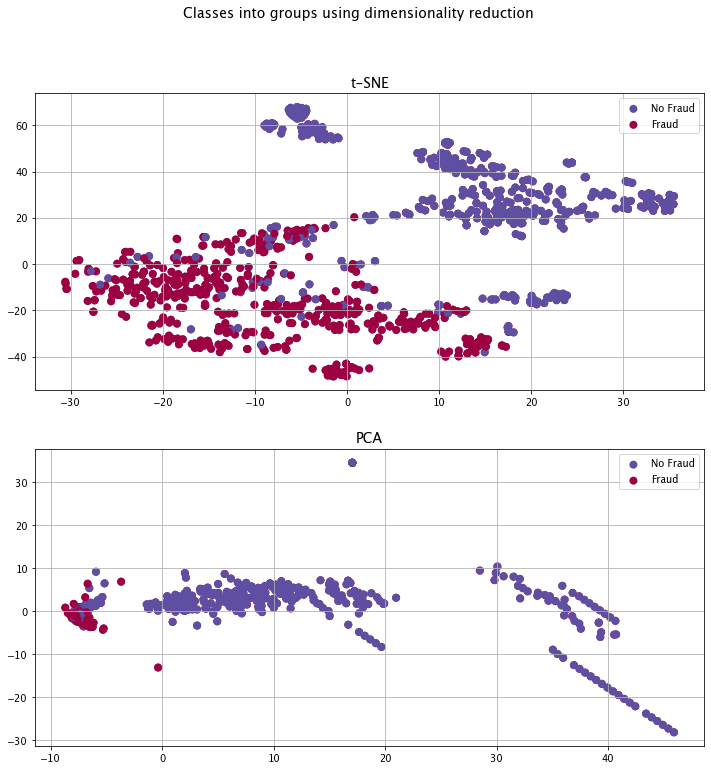

In [35]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 12))

f.suptitle("Classes into groups using dimensionality reduction", fontsize=14)

# t-SNE plot
ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=(y==0), cmap="Spectral", label="No Fraud", linewidths=2)
ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=(y==1), cmap="Spectral", label="Fraud", linewidths=2)
ax1.set_title("t-SNE", fontsize=14)
ax1.grid(True)
ax1.legend()

# PCA plot
ax2.scatter(X_pca[:,0], X_pca[:,1], c=(y==0), cmap="Spectral", label="No Fraud", linewidths=2)
ax2.scatter(X_pca[:,0], X_pca[:,1], c=(y==1), cmap="Spectral", label="Fraud", linewidths=2)
ax2.set_title("PCA", fontsize=14)
ax2.grid(True)
ax2.legend()

plt.show()

Since, the dimensionality reductions methods can separate the two class well, then our predictive models should be able to learn how to classify a transaction as fraud or non-fraud.

In [36]:
new_usmpl_df.shape

(938, 31)

## Classifiers

In [40]:
X = new_usmpl_df.drop("Class", axis=1)
y = new_usmpl_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [42]:
# Classifiers

classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "SVM": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "XGB": XGBClassifier()
}

for key, classifier in classifiers.items():
    # classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: {} Has training score of {}% accuracy score".format(classifier.__class__.__name__, round(training_score.mean()*100, 2)))

Classifiers: LogisticRegression Has training score of 94.67% accuracy score
Classifiers: KNeighborsClassifier Has training score of 92.93% accuracy score
Classifiers: SVC Has training score of 93.6% accuracy score
Classifiers: DecisionTreeClassifier Has training score of 92.27% accuracy score
Classifiers: XGBClassifier Has training score of 94.93% accuracy score


### Hyperparameter search:

In [43]:
# scorer
scorer = {"f1": make_scorer(f1_score)}

# for Logistic Regression
# for L2 penalty 
log_reg_params_l2 = {"penalty": ["l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg_l2 = GridSearchCV(LogisticRegression(), log_reg_params_l2, cv=5, scoring=scorer, refit="f1")
grid_log_reg_l2.fit(X_train, y_train)

# best hyperparameter settings
log_reg_l2 = grid_log_reg_l2.best_estimator_

# for L1 penalty (solver must be liblinear)
log_reg_params_l1 = {"penalty": ["l1"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg_l1 = GridSearchCV(LogisticRegression(solver="liblinear"), log_reg_params_l1, cv=5, scoring=scorer, refit="f1")
grid_log_reg_l1.fit(X_train, y_train)

# best hyperparameter settings
log_reg_l1 = grid_log_reg_l1.best_estimator_

grid_log_reg = grid_log_reg_l2 if grid_log_reg_l2.best_score_ > grid_log_reg_l1.best_score_ else grid_log_reg_l1
log_reg = log_reg_l2 if grid_log_reg_l2.best_score_ > grid_log_reg_l1.best_score_ else log_reg_l1

In [44]:
grid_log_reg_l1.cv_results_["mean_test_f1"]

array([0.        , 0.89534558, 0.93569757, 0.94325327, 0.93946616,
       0.9355151 , 0.9342623 ])

In [45]:
# for knearest neighbor classifier
knears_params = {"n_neighbors": list(range(2,5,1)),
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, cv=5, scoring=scorer, refit="f1")
grid_knears.fit(X_train, y_train)

# best knearest neighbor classifier
knears_neighbors = grid_knears.best_estimator_

In [46]:
# for support vector classifier
svc_params = {"C": [0.5, 0.7, 0.9, 1], "kernel": ["rbf", "poly", "sigmoid", "linear"]}
grid_svc = GridSearchCV(SVC(), svc_params, cv=5, scoring=scorer, refit="f1")
grid_svc.fit(X_train, y_train)

# best estimator
svc = grid_svc.best_estimator_

In [47]:
# for DecisionTree classifier
tree_params = {"criterion": ["gini", "entropy"],
                "max_depth": list(range(2,4,1)),
                "min_samples_leaf": list(range(5,7,1))}


grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring=scorer, refit="f1")
grid_tree.fit(X_train, y_train)

# best estimator
tree_clf = grid_tree.best_estimator_

In [66]:
# for XGBoost classifier
xgb_params = {
            "learning_rate"    : [0.05, 0.1, 0.3] ,
            "max_depth"        : [ 12, 15]}

grid_xgb = GridSearchCV(XGBClassifier(), xgb_params, cv=5, scoring=scorer, refit="f1")
grid_xgb.fit(X_train, y_train)

# best estimator
xgb_clf = grid_xgb.best_estimator_

In [67]:
# getting the best hyperparameters for all the classifiers
print("Best Hyperparameters for the classifiers are:")
print("LogisticRegression Classifier: {}".format(grid_log_reg.best_params_))
print("KNearestNeighbor Classifier: {}".format(grid_knears.best_params_))
print("SVM Classifier: {}".format(grid_svc.best_params_))
print("DecisionTree Classifier: {}".format(grid_tree.best_params_))
print("XGBClassifier Classifier: {}".format(grid_xgb.best_params_))

Best Hyperparameters for the classifiers are:
LogisticRegression Classifier: {'C': 1, 'penalty': 'l1'}
KNearestNeighbor Classifier: {'algorithm': 'auto', 'n_neighbors': 4}
SVM Classifier: {'C': 1, 'kernel': 'linear'}
DecisionTree Classifier: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6}
XGBClassifier Classifier: {'learning_rate': 0.3, 'max_depth': 12}


In [68]:
# getting the best cross validation scores for all the classifiers
print("Best scores for the classifiers are:")
print("LogisticRegression Classifier: {}".format(max(grid_log_reg.cv_results_["mean_test_f1"])))
print("KNearestNeighbor Classifier: {}".format(max(grid_knears.cv_results_["mean_test_f1"])))
print("SVM Classifier: {}".format(max(grid_svc.cv_results_["mean_test_f1"])))
print("DecisionTree Classifier: {}".format(max(grid_tree.cv_results_["mean_test_f1"])))
print("XGBClassifier Classifier: {}".format(max(grid_xgb.cv_results_["mean_test_f1"])))

Best scores for the classifiers are:
LogisticRegression Classifier: 0.9432532684706597
KNearestNeighbor Classifier: 0.9308659935528185
SVM Classifier: 0.942078337330136
DecisionTree Classifier: 0.9215417665673977
XGBClassifier Classifier: 0.9440062235841588


### Plotting ROC curves:

In [69]:
# predicting with classifiers and getting the decision function values
log_reg_pred = log_reg.decision_function(X_test)
knears_pred = knears_neighbors.predict_proba(X_test)[:,1]
svc_pred = svc.decision_function(X_test)
tree_clf_pred = tree_clf.predict_proba(X_test)[:,1]
xgb_clf_pred = xgb_clf.predict_proba(X_test)[:, 1]

# predicting the class of the test samples
log_reg_pred_cls = log_reg.predict(X_test)
knears_pred_cls = knears_neighbors.predict(X_test)
svc_pred_cls = svc.predict(X_test)
tree_clf_pred_cls = tree_clf.predict(X_test)
xgb_clf_pred_cls = xgb_clf.predict(X_test)

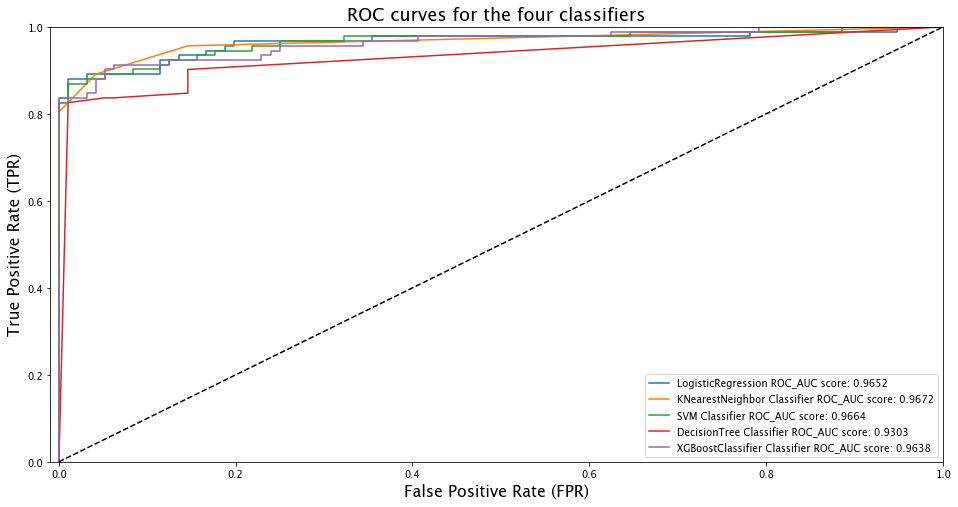

In [70]:
# creating ROC curves
log_fpr, log_tpr, log_threshold = roc_curve(y_test, log_reg_pred)
knears_fpr, knears_tpr, knears_threshold = roc_curve(y_test, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_clf_pred)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, xgb_clf_pred)

plt.figure(figsize=(16, 8))
plt.title("ROC curves for the four classifiers", fontsize=18)
plt.plot(log_fpr, log_tpr, label="LogisticRegression ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, log_reg_pred)))
plt.plot(knears_fpr, knears_tpr, label="KNearestNeighbor Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, knears_pred)))
plt.plot(svc_fpr, svc_tpr, label="SVM Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, svc_pred)))
plt.plot(tree_fpr, tree_tpr, label="DecisionTree Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, tree_clf_pred)))
plt.plot(xgb_fpr, xgb_tpr, label="XGBoostClassifier Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, xgb_clf_pred)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel("False Positive Rate (FPR)", fontsize=16)
plt.ylabel("True Positive Rate (TPR)", fontsize=16)
plt.legend()
plt.show()

### Confusion Matrices:

In [71]:
# function to plot confusion matrix
def plot_confusion_matrix(cnf_mat, class_names, title, axis):
    cmap = plt.cm.Blues
    img = axis.imshow(cnf_mat, interpolation= 'nearest', cmap=cmap)
    axis.set_title(title, fontsize=14)
    plt.colorbar(img, ax=axis)
    tick_marks = np.arange(len(class_names))
    axis.set_xticks(tick_marks, class_names, rotation=0)
    axis.set_yticks(tick_marks, class_names)

    thresh = cnf_mat.max()/2.0
    for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
        axis.text(j, i, cnf_mat[i, j],
                horizontalalignment='center',
                color="white" if cnf_mat[i,j] > thresh else "black")

    axis.set_ylabel("True Label")
    axis.set_xlabel("Predicted Label")


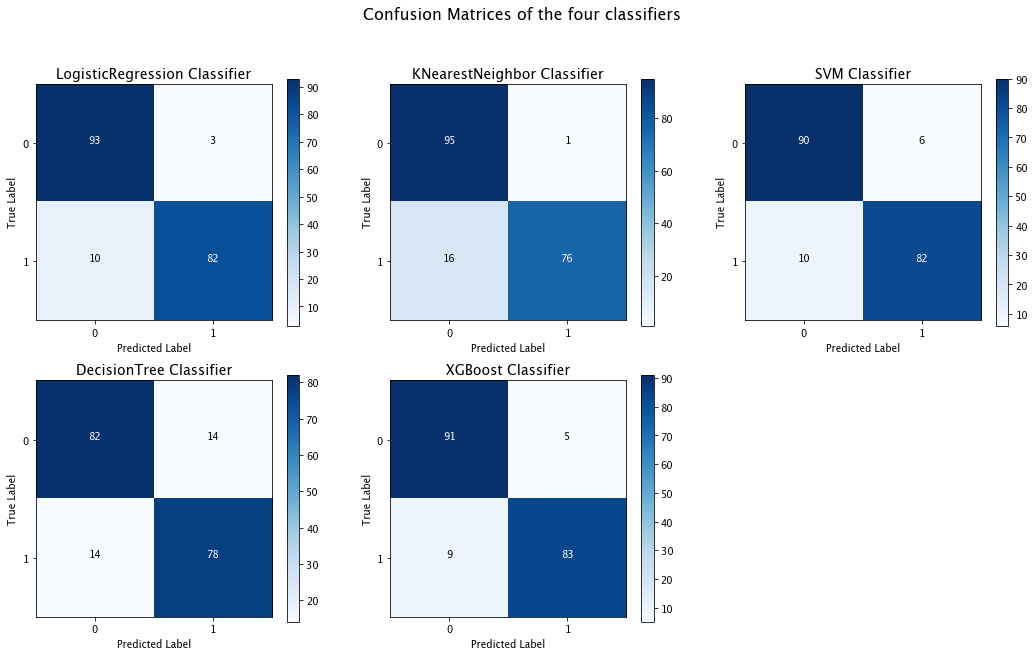

In [72]:

log_cnf_matrix = confusion_matrix(y_test, log_reg_pred_cls)
knears_cnf_matrix = confusion_matrix(y_test, knears_pred_cls)
svc_cnf_matrix = confusion_matrix(y_test, svc_pred_cls)
tree_cnf_matrix = confusion_matrix(y_test, tree_clf_pred_cls)
xgb_cnf_matrix = confusion_matrix(y_test, xgb_clf_pred_cls)


f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
f.delaxes(ax6)
# f.tight_layout(h_pad=2, v_pad=2)
plot_confusion_matrix(log_cnf_matrix, class_names=[0,1], title="LogisticRegression Classifier", axis=ax1)
plot_confusion_matrix(knears_cnf_matrix, class_names=[0,1], title="KNearestNeighbor Classifier", axis=ax2)
plot_confusion_matrix(svc_cnf_matrix, class_names=[0,1], title="SVM Classifier", axis=ax3)
plot_confusion_matrix(tree_cnf_matrix, class_names=[0,1], title="DecisionTree Classifier", axis=ax4)
plot_confusion_matrix(xgb_cnf_matrix, class_names=[0,1], title="XGBoost Classifier", axis=ax5)
plt.suptitle("Confusion Matrices of the four classifiers", fontsize=16)
plt.show()

### Plotting Precision-Recall curves:

In [73]:
aps_log = average_precision_score(y_test, log_reg_pred)
aps_knears = average_precision_score(y_test, knears_pred)
aps_svc = average_precision_score(y_test, svc_pred)
aps_tree = average_precision_score(y_test, tree_clf_pred)
aps_xgb = average_precision_score(y_test, xgb_clf_pred)

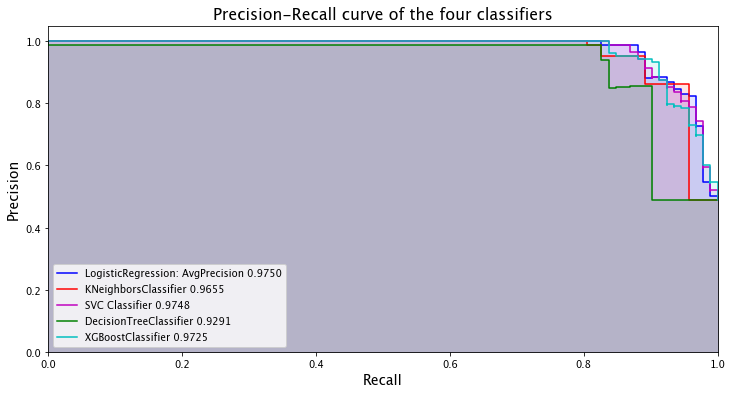

In [76]:
log_precision, log_recall, _ = precision_recall_curve(y_test, log_reg_pred)
knears_precision, knears_recall, _ = precision_recall_curve(y_test, knears_pred)
svc_precision, svc_recall, _ = precision_recall_curve(y_test, svc_pred)
tree_precision, tree_recall, _ = precision_recall_curve(y_test, tree_clf_pred)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_clf_pred)

fig = plt.figure(figsize=(12,6))

plt.step(log_recall, log_precision, where='post', color='b', 
        label="LogisticRegression: AvgPrecision {0:.4f}".format(aps_log))
plt.fill_between(log_recall, log_precision, step="post", alpha=0.1, color='b')

plt.step(knears_recall, knears_precision, where='post', color='r',
        label="KNeighborsClassifier {0:.4f}".format(aps_knears))
plt.fill_between(knears_recall, knears_precision, step="post", alpha=0.1, color='r')

plt.step(svc_recall, svc_precision, where='post', color='m',
        label="SVC Classifier {0:.4f}".format(aps_svc))
plt.fill_between(svc_recall, svc_precision, step="post", alpha=0.1, color='m')

plt.step(tree_recall, tree_precision, where='post', color='g',
        label="DecisionTreeClassifier {0:.4f}".format(aps_tree))
plt.fill_between(tree_recall, tree_precision, step="post", alpha=0.1, color='g')

plt.step(xgb_recall, xgb_precision, where='post', color='c',
        label="XGBoostClassifier {0:.4f}".format(aps_xgb))
plt.fill_between(xgb_recall, xgb_precision, step="post", alpha=0.1, color='c')

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve of the four classifiers", fontsize=16)
plt.legend()
plt.show()


### Discussion:

From the above results we can see that all the classifiers perform similarly on the unseen test data (under-sampled), but LogisticRegression classifier performs the best among all. However, LogisticRegression and XGBoost classifiers perform almost similarly with very similar performance metrices.

* The ROC AUC score is highest for LogisticRegression Classifier
* The default recall and precision calculated from the confusion matrices are similar for all the classifiers.
* The AveragePrecision score is highest for LogisticRegression Classifier.

Now, we will take these trained models and predict for the entire dataset to see how they perform.

## Testing on the entire data:

### Plotting Confusion matrices for the entire data:

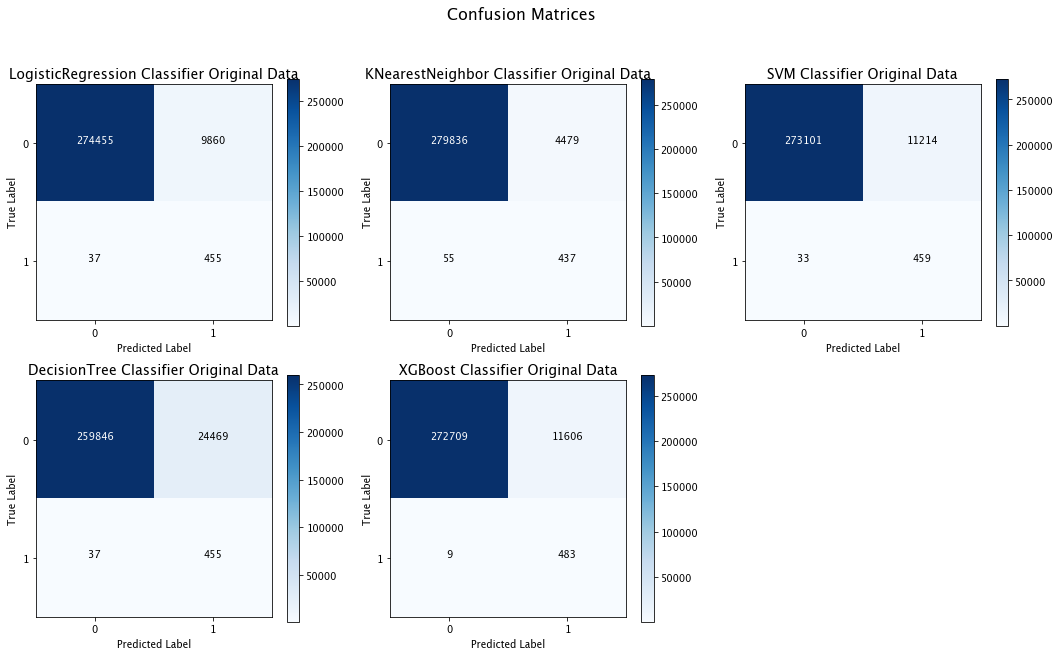

In [77]:
X_orig = df.drop("Class", axis=1)
y_orig = df["Class"]

y_pred_orig_log = log_reg.predict(X_orig)
y_pred_orig_knears = knears_neighbors.predict(X_orig)
y_pred_orig_svc = svc.predict(X_orig)
y_pred_orig_tree = tree_clf.predict(X_orig)
y_pred_orig_xgb = xgb_clf.predict(X_orig)

log_cnf_matrix_orig = confusion_matrix(y_orig, y_pred_orig_log)
knears_cnf_matrix_orig = confusion_matrix(y_orig, y_pred_orig_knears)
svc_cnf_matrix_orig = confusion_matrix(y_orig, y_pred_orig_svc)
tree_cnf_matrix_orig = confusion_matrix(y_orig, y_pred_orig_tree)
xgb_cnf_matrix_orig = confusion_matrix(y_orig, y_pred_orig_xgb)


f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
f.delaxes(ax6)
# f.tight_layout(h_pad=2, v_pad=2)
plot_confusion_matrix(log_cnf_matrix_orig, class_names=[0,1], title="LogisticRegression Classifier Original Data", axis=ax1)
plot_confusion_matrix(knears_cnf_matrix_orig, class_names=[0,1], title="KNearestNeighbor Classifier Original Data", axis=ax2)
plot_confusion_matrix(svc_cnf_matrix_orig, class_names=[0,1], title="SVM Classifier Original Data", axis=ax3)
plot_confusion_matrix(tree_cnf_matrix_orig, class_names=[0,1], title="DecisionTree Classifier Original Data", axis=ax4)
plot_confusion_matrix(xgb_cnf_matrix_orig, class_names=[0,1], title="XGBoost Classifier Original Data", axis=ax5)
plt.suptitle("Confusion Matrices", fontsize=16)
plt.show()

### Precision Recall curve with entire data

In [78]:
y_pred_orig_log_prob = log_reg.decision_function(X_orig)
y_pred_orig_knears_prob = knears_neighbors.predict_proba(X_orig)[:,1]
y_pred_orig_svc_prob = svc.decision_function(X_orig)
y_pred_orig_tree_prob = tree_clf.predict_proba(X_orig)[:,1]
y_pred_orig_xgb_prob = xgb_clf.predict_proba(X_orig)[:,1]

aps_log_orig = average_precision_score(y_orig, y_pred_orig_log_prob)
aps_knears_orig = average_precision_score(y_orig, y_pred_orig_knears_prob)
aps_svc_orig = average_precision_score(y_orig, y_pred_orig_svc_prob)
aps_tree_orig = average_precision_score(y_orig, y_pred_orig_tree_prob)
aps_xgb_orig = average_precision_score(y_orig, y_pred_orig_xgb_prob)

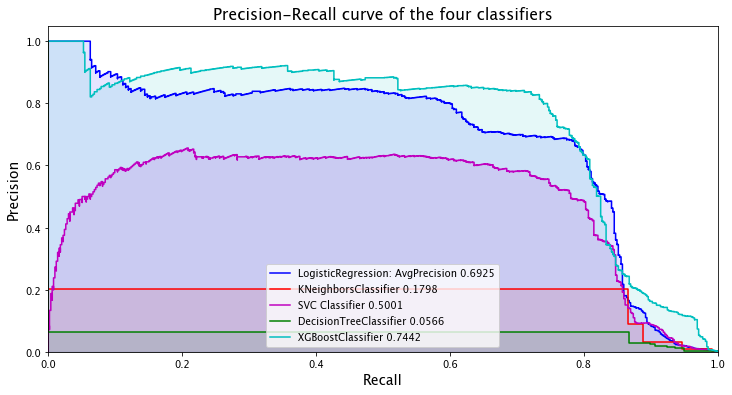

In [79]:
# Creating the precision recall curve and plotting it
log_precision_orig, log_recall_orig, _ = precision_recall_curve(y_orig, y_pred_orig_log_prob)
knears_precision_orig, knears_recall_orig, _ = precision_recall_curve(y_orig, y_pred_orig_knears_prob)
svc_precision_orig, svc_recall_orig, _ = precision_recall_curve(y_orig, y_pred_orig_svc_prob)
tree_precision_orig, tree_recall_orig, _ = precision_recall_curve(y_orig, y_pred_orig_tree_prob)
xgb_precision_orig, xgb_recall_orig, _ = precision_recall_curve(y_orig, y_pred_orig_xgb_prob)

fig = plt.figure(figsize=(12,6))

plt.step(log_recall_orig, log_precision_orig, where='post', color='b', 
        label="LogisticRegression: AvgPrecision {0:.4f}".format(aps_log_orig))
plt.fill_between(log_recall_orig, log_precision_orig, step="post", alpha=0.1, color='b')

plt.step(knears_recall_orig, knears_precision_orig, where='post', color='r',
        label="KNeighborsClassifier {0:.4f}".format(aps_knears_orig))
plt.fill_between(knears_recall_orig, knears_precision_orig, step="post", alpha=0.1, color='r')

plt.step(svc_recall_orig, svc_precision_orig, where='post', color='m',
        label="SVC Classifier {0:.4f}".format(aps_svc_orig))
plt.fill_between(svc_recall_orig, svc_precision_orig, step="post", alpha=0.1, color='m')

plt.step(tree_recall_orig, tree_precision_orig, where='post', color='g',
        label="DecisionTreeClassifier {0:.4f}".format(aps_tree_orig))
plt.fill_between(tree_recall_orig, tree_precision_orig, step="post", alpha=0.1, color='g')

plt.step(xgb_recall_orig, xgb_precision_orig, where='post', color='c',
        label="XGBoostClassifier {0:.4f}".format(aps_xgb_orig))
plt.fill_between(xgb_recall_orig, xgb_precision_orig, step="post", alpha=0.1, color='c')

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve of the four classifiers", fontsize=16)
plt.legend()
plt.show()

### Plotting ROC curves for the entire data:

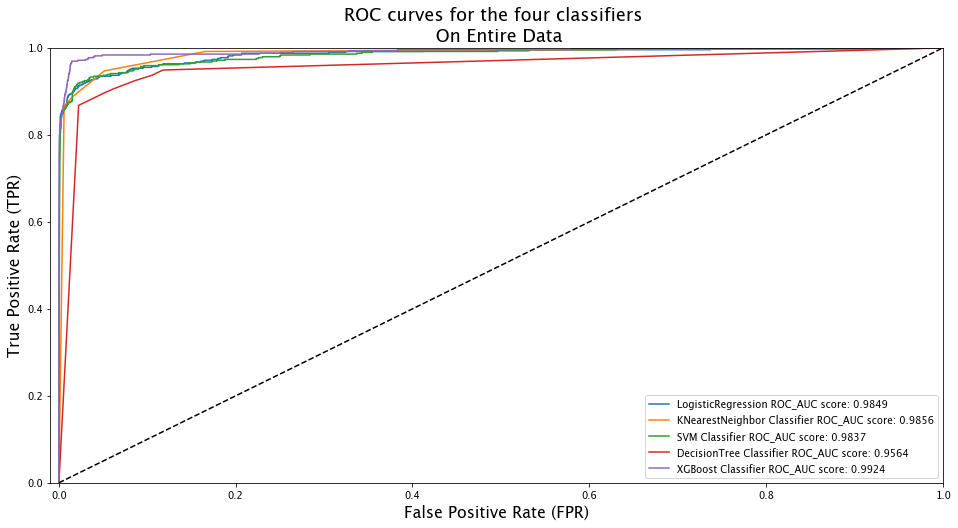

In [80]:
# creating ROC curves
log_fpr, log_tpr, log_threshold = roc_curve(y_orig, y_pred_orig_log_prob)
knears_fpr, knears_tpr, knears_threshold = roc_curve(y_orig, y_pred_orig_knears_prob)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_orig, y_pred_orig_svc_prob)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_orig, y_pred_orig_tree_prob)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_orig, y_pred_orig_xgb_prob)

plt.figure(figsize=(16, 8))
plt.title("ROC curves for the four classifiers \n On Entire Data", fontsize=18)
plt.plot(log_fpr, log_tpr, label="LogisticRegression ROC_AUC score: {0:.4f}".format(roc_auc_score(y_orig, y_pred_orig_log_prob)))
plt.plot(knears_fpr, knears_tpr, label="KNearestNeighbor Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_orig, y_pred_orig_knears_prob)))
plt.plot(svc_fpr, svc_tpr, label="SVM Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_orig, y_pred_orig_svc_prob)))
plt.plot(tree_fpr, tree_tpr, label="DecisionTree Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_orig, y_pred_orig_tree_prob)))
plt.plot(xgb_fpr, xgb_tpr, label="XGBoost Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_orig, y_pred_orig_xgb_prob)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel("False Positive Rate (FPR)", fontsize=16)
plt.ylabel("True Positive Rate (TPR)", fontsize=16)
plt.legend()
plt.show()

### Discussion:

As we can see from the above results, that XGBoost Classifier is generalizing the learning well on the entire dataset compare to the rest of the models. However, the recall and precision can be improved further using techniques like over-sampling (using SMOTE). We will look into SMOTE in the next section of this notbook.

# XGBoost Classifier Using Oversampling method: SMOTE

In [117]:
data = pd.read_csv("./data/creditcard.csv")
data = data.sample(frac=1)

In [118]:
# data preprocessing
data[["Amount"]] = amount_scaler.transform(data[["Amount"]])
data[["Time"]] = time_scaler.transform(data[["Time"]])
data = data.reset_index(drop=True)

In [119]:

X = data.drop(["Class"], axis=1)
y = data["Class"]

X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("The fraction of fraud transactions in Train set is: {0:.2f}%".format(100*y_train_orig.value_counts()[1]/y_train_orig.shape[0]))
print("The fraction of fraud transactions in test set is: {0:.2f}%".format(100*y_test.value_counts()[1]/y_test.shape[0]))

The fraction of fraud transactions in Train set is: 0.17%
The fraction of fraud transactions in test set is: 0.17%


In [120]:
print("Number of training set samples for each class:")
print(y_train_orig.value_counts())
print("\nNumber of test set samples for each class:")
print(y_test.value_counts())


Number of training set samples for each class:
0    227449
1       396
Name: Class, dtype: int64

Number of test set samples for each class:
0    56866
1       96
Name: Class, dtype: int64


In [129]:
# Initiating stratified K fold class
stratKfold = StratifiedKFold(n_splits=5)

# for XGBoost classifier
xgb_params = {
            "learning_rate"    : [0.05, 0.1, 0.3] ,
            "max_depth"        : [ 12, 15]}

rand_xgb = RandomizedSearchCV(XGBClassifier(), xgb_params, n_iter=5)

best_params = []
f1_scores = []
recalls = []
precesions = []
auc_scores = []

# starting the training on different folds and then applying SMOTE in each iteration of the folds
# for train_idx, test_idx in stratKfold.split(X_train_orig, y_train_orig):
    # oversampling will happen on this current train and test data
pipe = make_pipeline(SMOTE(sampling_strategy="minority"), rand_xgb)

model = pipe.fit(X_train_orig, y_train_orig)
best_estimator = rand_xgb.best_estimator_
best_params.append(rand_xgb.best_params_)

preds = best_estimator.predict(X_train_orig)
preds_proba = best_estimator.predict_proba(X_train_orig)[:,1]
f1_score_ = f1_score(y_train_orig, preds)
recall_ = recall_score(y_train_orig, preds)
precesion_ = precision_score(y_train_orig, preds)
auc_score_ = roc_auc_score(y_train_orig, preds_proba)


In [140]:
print("Recall: {}".format(recall_))
print("Precision: {}".format(precesion_))
print("f1_score: {}".format(f1_score_))
print("roc auc score: {}".format(auc_score_))
print("Best hyperparameters: {}".format(best_params)) 
#Best hyperparameters: [{'max_depth': 12, 'learning_rate': 0.3}]

Recall: 1.0
Precision: 1.0
f1_score: 1.0
roc auc score: 1.0
Best hyperparameters: [{'max_depth': 12, 'learning_rate': 0.3}]


In [138]:
# on test set
test_preds = best_estimator.predict(X_test)
test_preds_probs = best_estimator.predict_proba(X_test)[:,1]
test_f1_score_ = f1_score(y_test, test_preds)
test_recall_ = recall_score(y_test, test_preds)
test_precesion_ = precision_score(y_test, test_preds)
test_auc_score_ = roc_auc_score(y_test, test_preds_probs)

print("Test Recall: {}".format(test_recall_))
print("Test Precision: {}".format(test_precesion_))
print("Test f1_score: {}".format(test_f1_score_))
print("Test roc auc score: {}".format(test_auc_score_))

Test Recall: 0.7916666666666666
Test Precision: 0.8172043010752689
Test f1_score: 0.8042328042328043
Test roc auc score: 0.9880230131654534


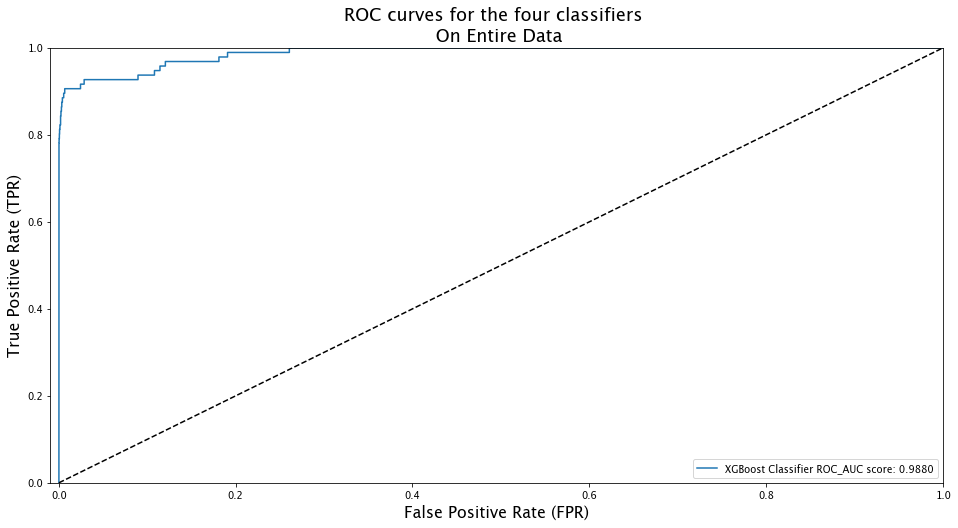

In [134]:
y_pred_test_prob = best_estimator.predict_proba(X_test)[:,1]
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, y_pred_test_prob)

plt.figure(figsize=(16, 8))
plt.title("ROC curves for the four classifiers \n On Entire Data", fontsize=18)

plt.plot(xgb_fpr, xgb_tpr, label="XGBoost Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, y_pred_test_prob)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel("False Positive Rate (FPR)", fontsize=16)
plt.ylabel("True Positive Rate (TPR)", fontsize=16)
plt.legend()
plt.show()

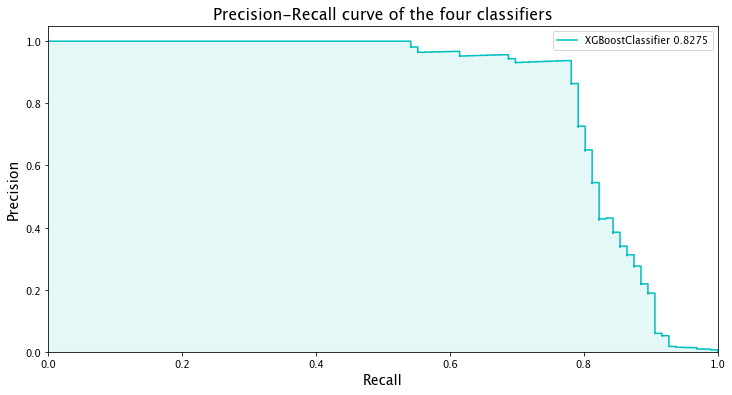

In [136]:
xgb_precision_orig, xgb_recall_orig, _ = precision_recall_curve(y_test, y_pred_test_prob)
aps_xgb_orig = average_precision_score(y_test, y_pred_test_prob)

fig = plt.figure(figsize=(12,6))

plt.step(xgb_recall_orig, xgb_precision_orig, where='post', color='c',
        label="XGBoostClassifier {0:.4f}".format(aps_xgb_orig))
plt.fill_between(xgb_recall_orig, xgb_precision_orig, step="post", alpha=0.1, color='c')

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve of the four classifiers", fontsize=16)
plt.legend()
plt.show()

### Discussion:

As we can see from the above results, that XGBoost Classifier is generalizing the learning well on the unseen test data. We have achieved a recall of 79\% and f1 score as 80%. We will use the hyperparameters identified in this notebook to create a Docker container and deploy that using AWS sagemaker.